# Worksheet 6 - HA Two Heated Tanks

**Student:** Lucas de Oliveira Martim

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import bisect as bi

def edInt(a, s, b):
    """Create evenly discretized interval from a to b with step s"""
    return np.linspace(a, b, int(np.floor((b-a)/s)) + 1)

def idx(aList, val):
    """Find nearest index in sorted list for given value"""
    i = bi.bisect(aList, val)  # right insertion point
    if i <= 0:  # val is before first element
        return 0
    elif i >= len(aList):  # val is after last element
        return len(aList) - 1
    elif val - aList[i-1] < aList[i] - val:  # closer to left
        return i - 1
    else:  # closer to right
        return i

def lookup(aList, vals):
    """Find nearest indices for values (nearest-neighbor interpolation)"""
    if isinstance(vals, (int, float, np.floating)):
        vals = [vals]
    return np.array([idx(aList, v) for v in vals], dtype=np.int32)

In [26]:
a1 = 0.01   # Heat loss coefficient tank 1
a2 = 0.01   # Heat loss coefficient tank 2
b1 = 0.005  # Coupling coefficient 2 to 1
b2 = 0.005  # Coupling coefficient 1 to 2
h1 = 2.0    # Heater gain tank 1
h2 = 2.0    # Heater gain tank 2

t0, dt, tf = 0, 1, 100

T_time = edInt(t0, dt, tf)
N = T_time.size

# Initial and reference states
x0 = np.array([0.0, 40.0])
x_ref = np.array([25.0, 30.0])

# Penalty for inadmissible states
infStValInc = 1e6
nullCtr = 0.0

T_MIN = 0   # Minimum temperature for both tanks
T_MAX = 100 # Maximum temperature for both tanks

dT = 2 # Temperature step for both tanks [C]

# Control limits
U_MIN = 0 # Minimum control input (heater off)
U_MAX = 1 # Maximum control input (heater full)
dU = 1         # Control step

# Cost weights (used consistently across all controllers)
Q1_COST = 10.0  # State cost weight for Tank 1
Q2_COST = 10.0  # State cost weight for Tank 2
R1_COST = 1.0   # Control cost weight for Heater 1
R2_COST = 1.0   # Control cost weight for Heater 2
# =============================================================================

U = edInt(U_MIN, dU, U_MAX)
T1_mesh, T2_mesh = np.meshgrid(edInt(T_MIN, dT, T_MAX), edInt(T_MIN, dT, T_MAX))

## Configuration for SISO Controllers

In [27]:
# SISO Controller 1 (Tank 1): State space includes both T1 and T2, but only u1 is controlled
# Using GLOBAL CONFIG
dT1_b1 = dT    # Temperature step for tank 1
dT2_b1 = dT    # Temperature step for tank 2 (disturbance)

T_MIN, T_MAX = T_MIN, T_MAX
du1_b1 = dU   # Control step for heater 1
u1_min_b1, u1_max_b1 = U_MIN, U_MAX

# Create grids for Controller 1
T1_grid_b1 = edInt(T_MIN, dT1_b1, T_MAX)
T2_grid_b1 = edInt(T_MIN, dT2_b1, T_MAX)
U1_b1 = U
T1_mesh_b1, T2_mesh_b1 = np.meshgrid(T1_grid_b1, T2_grid_b1)

# SISO Controller 2 (Tank 2): State space includes both T1 and T2, but only u2 is controlled
# Using GLOBAL CONFIG
dT1_b2 = dT    # Temperature step for tank 1 (disturbance)
dT2_b2 = dT    # Temperature step for tank 2
T_MIN, T_MAX = T_MIN, T_MAX
T_MIN, T_MAX = T_MIN, T_MAX
du2_b2 = dU   # Control step for heater 2
u2_min_b2, u2_max_b2 = U_MIN, U_MAX

# Create grids for Controller 2
T1_grid_b2 = edInt(T_MIN, dT1_b2, T_MAX)
T2_grid_b2 = edInt(T_MIN, dT2_b2, T_MAX)
U2_b2 = U
T1_mesh_b2, T2_mesh_b2 = np.meshgrid(T1_grid_b2, T2_grid_b2)

# Cost weights for SISO controllers - using GLOBAL CONFIG
Q1_b1 = Q1_COST   # State cost for Tank 1 in Controller 1
Q2_b1 = 0.0    # No direct cost for Tank 2 in Controller 1 (it's a disturbance)
R1_b1 = R1_COST    # Control cost for u1

Q1_b2 = 0.0    # No direct cost for Tank 1 in Controller 2 (it's a disturbance)
Q2_b2 = Q2_COST   # State cost for Tank 2 in Controller 2
R2_b2 = R2_COST    # Control cost for u2

In [28]:
V_b1 = np.zeros((T2_grid_b1.size, T1_grid_b1.size, N))
u1_opt_b1 = np.zeros_like(V_b1)
V_b1[:, :, N-1] = Q1_b1 * (T1_mesh_b1 - x_ref[0])**2 + Q2_b1 * (T2_mesh_b1 - x_ref[1])**2

inadmissible_count_b1 = 0

for k in range(N-2, -1, -1):
    if k % 20 == 0:
        print(f"  Processing time step {k}/{N-1}...")
    
    for i in range(T2_grid_b1.size):
        for j in range(T1_grid_b1.size):
            T1_curr = T1_grid_b1[j]
            T2_curr = T2_grid_b1[i]
            
            min_cost = float('inf')
            best_u1 = nullCtr
            
            # Only optimize over u1 (u2 = 0 fixed)
            for u1_val in U1_b1:
                u2_val = 0.0  # Controller 1 doesn't control Tank 2
                
                # Instant cost (only Tank 1 error)
                L = Q1_b1 * (T1_curr - x_ref[0])**2 + R1_b1 * u1_val**2
                
                # Predict next state
                T1_next = T1_curr + (-a1 * T1_curr + b1 * T2_curr + h1 * u1_val) * dt
                T2_next = T2_curr + (b2 * T1_curr - a2 * T2_curr + h2 * u2_val) * dt
                
                # Check admissibility
                if (T1_next >= T_MIN and T1_next <= T_MAX and 
                    T2_next >= T_MIN and T2_next <= T_MAX):
                    
                    j_next = lookup(T1_grid_b1, T1_next)[0]
                    i_next = lookup(T2_grid_b1, T2_next)[0]
                    
                    total_cost = L + V_b1[i_next, j_next, k+1]
                    
                    if total_cost < min_cost:
                        min_cost = total_cost
                        best_u1 = u1_val
            
            if min_cost == float('inf'):
                V_b1[i, j, k] = V_b1[i, j, k+1] + infStValInc
                inadmissible_count_b1 += 1
            else:
                V_b1[i, j, k] = min_cost
            
            u1_opt_b1[i, j, k] = best_u1

print(f"  Inadmissible states encountered: {inadmissible_count_b1}")

  Processing time step 80/100...
  Processing time step 60/100...
  Processing time step 40/100...
  Processing time step 20/100...
  Processing time step 0/100...
  Inadmissible states encountered: 0


In [29]:
# Initialize for Controller 2
V_b2 = np.zeros((T2_grid_b2.size, T1_grid_b2.size, N))
u2_opt_b2 = np.zeros_like(V_b2)

# Terminal cost (only Tank 2 error matters)
V_b2[:, :, N-1] = Q1_b2 * (T1_mesh_b2 - x_ref[0])**2 + Q2_b2 * (T2_mesh_b2 - x_ref[1])**2

print("SISO Controller 2 - Backward pass...")

inadmissible_count_b2 = 0

for k in range(N-2, -1, -1):
    if k % 20 == 0:
        print(f"Processing time step {k}/{N-1}...")
    
    for i in range(T2_grid_b2.size):
        for j in range(T1_grid_b2.size):
            T1_curr = T1_grid_b2[j]
            T2_curr = T2_grid_b2[i]
            
            min_cost = float('inf')
            best_u2 = nullCtr
            
            # Only optimize over u2 (u1 = 0 fixed)
            for u2_val in U2_b2:
                u1_val = 0.0  # Controller 2 doesn't control Tank 1
                
                # Instant cost (only Tank 2 error)
                L = Q2_b2 * (T2_curr - x_ref[1])**2 + R2_b2 * u2_val**2
                
                # Predict next state
                T1_next = T1_curr + (-a1 * T1_curr + b1 * T2_curr + h1 * u1_val) * dt
                T2_next = T2_curr + (b2 * T1_curr - a2 * T2_curr + h2 * u2_val) * dt
                
                # Check admissibility
                if (T1_next >= T_MIN and T1_next <= T_MAX and 
                    T2_next >= T_MIN and T2_next <= T_MAX):
                    
                    j_next = lookup(T1_grid_b2, T1_next)[0]
                    i_next = lookup(T2_grid_b2, T2_next)[0]
                    
                    total_cost = L + V_b2[i_next, j_next, k+1]
                    
                    if total_cost < min_cost:
                        min_cost = total_cost
                        best_u2 = u2_val
            
            if min_cost == float('inf'):
                V_b2[i, j, k] = V_b2[i, j, k+1] + infStValInc
                inadmissible_count_b2 += 1
            else:
                V_b2[i, j, k] = min_cost
            
            u2_opt_b2[i, j, k] = best_u2

print(f"SISO Controller 2 backward pass complete!")
print(f"Inadmissible states encountered: {inadmissible_count_b2}")

SISO Controller 2 - Backward pass...
Processing time step 80/100...
Processing time step 60/100...
Processing time step 40/100...
Processing time step 20/100...
Processing time step 0/100...
SISO Controller 2 backward pass complete!
Inadmissible states encountered: 0


# Part (c): Hybrid Automaton - Switching Between SISO Controllers

Implement the hybrid automaton (HA) to switch between the two SISO controllers using appropriate tolerance for jump guards.

**Strategy:**
- **Mode 1 (Controller 1)**: Active when Tank 1 error is larger - use SISO Controller 1 (u1, u2=0)
- **Mode 2 (Controller 2)**: Active when Tank 2 error is larger - use SISO Controller 2 (u2, u1=0)

**Guard Conditions:**
- Switch from Mode 1 to Mode 2 when: $|T_2 - T_2^{ref}| > |T_1 - T_1^{ref}| + \epsilon$
- Switch from Mode 2 to Mode 1 when: $|T_1 - T_1^{ref}| > |T_2 - T_2^{ref}| + \epsilon$

## Configuration

In [30]:
# Hybrid automaton configuration
MODE_CTRL1 = 0  # Use SISO Controller 1 (focus on Tank 1)
MODE_CTRL2 = 1  # Use SISO Controller 2 (focus on Tank 2)

mode_names_c = {
    MODE_CTRL1: "Controller 1 (Tank 1)",
    MODE_CTRL2: "Controller 2 (Tank 2)"
}

# Switching tolerance (hysteresis to prevent chattering)
epsilon_switch = 0.5  # Temperature tolerance in C

print(f"Configuration:")
print(f"Modes: 2 (SISO Controller 1, SISO Controller 2)")
print(f"Switching tolerance: {epsilon_switch}C")

Configuration:
Modes: 2 (SISO Controller 1, SISO Controller 2)
Switching tolerance: 0.5C


## Hybrid Automaton Simulation

Simulate the system with mode switching based on error magnitudes.

In [31]:
T1_grid_b1 = edInt(T_MIN, dT1_b1, T1_max_b1)
T2_grid_b1 = edInt(T_MIN, dT2_b1, T_MAX)

NameError: name 'T1_max_b1' is not defined

In [ ]:
# Initialize simulation
x_c = np.zeros((N, 2))
x_c[0, :] = x0
u1_sim_c = np.zeros(N)
u2_sim_c = np.zeros(N)
mode_traj_c = np.zeros(N, dtype=int)

# Determine initial mode based on which error is larger
error_T1_init = abs(x0[0] - x_ref[0])
error_T2_init = abs(x0[1] - x_ref[1])

if error_T1_init > error_T2_init:
    current_mode = MODE_CTRL1
else:
    current_mode = MODE_CTRL2

mode_traj_c[0] = current_mode

print(f"Starting hybrid automaton simulation...")
print(f"Initial errors: T1={error_T1_init:.2f}C, T2={error_T2_init:.2f}C")
print(f"Starting in mode: {mode_names_c[current_mode]}")

for k in range(N-1):
    # Check bounds - using GLOBAL CONFIG
    if not (x_c[k, 0] >= T_MIN and x_c[k, 0] <= T_MAX and
            x_c[k, 1] >= T_MIN and x_c[k, 1] <= T_MAX):
        print(f"Warning: Stopped at k={k}/{N}: state out of bounds")
        x_c = x_c[:k+1, :]
        u1_sim_c = u1_sim_c[:k+1]
        u2_sim_c = u2_sim_c[:k+1]
        mode_traj_c = mode_traj_c[:k+1]
        break
    
    # Get current errors
    error_T1 = abs(x_c[k, 0] - x_ref[0])
    error_T2 = abs(x_c[k, 1] - x_ref[1])
    
    # Check for mode switching (with hysteresis)
    if current_mode == MODE_CTRL1:
        # Switch to Controller 2 if Tank 2 error is significantly larger
        if error_T2 > error_T1 + epsilon_switch:
            current_mode = MODE_CTRL2
    else:  # current_mode == MODE_CTRL2
        # Switch to Controller 1 if Tank 1 error is significantly larger
        if error_T1 > error_T2 + epsilon_switch:
            current_mode = MODE_CTRL1
    
    mode_traj_c[k] = current_mode
    
    # Apply control based on current mode
    j_T1 = lookup(T1_grid_b1, x_c[k, 0])[0]  # Both grids are the same
    i_T2 = lookup(T2_grid_b1, x_c[k, 1])[0]
    
    if current_mode == MODE_CTRL1:
        # Use SISO Controller 1
        u1_sim_c[k] = u1_opt_b1[i_T2, j_T1, k]
        u2_sim_c[k] = 0.0
    else:  # MODE_CTRL2
        # Use SISO Controller 2
        u1_sim_c[k] = 0.0
        u2_sim_c[k] = u2_opt_b2[i_T2, j_T1, k]
    
    # Propagate dynamics
    x_c[k+1, 0] = x_c[k, 0] + (-a1 * x_c[k, 0] + b1 * x_c[k, 1] + h1 * u1_sim_c[k]) * dt
    x_c[k+1, 1] = x_c[k, 1] + (b2 * x_c[k, 0] - a2 * x_c[k, 1] + h2 * u2_sim_c[k]) * dt

# Set final mode
mode_traj_c[-1] = current_mode

# Count mode switches
mode_switches_c = np.sum(mode_traj_c[1:] != mode_traj_c[:-1])

print(f"Simulation complete!")
print(f"Final state: T1={x_c[-1,0]:.2f}C, T2={x_c[-1,1]:.2f}C")
print(f"Reference:   T1={x_ref[0]}C, T2={x_ref[1]}C")
print(f"Final error: T1={x_c[-1,0]-x_ref[0]:.2f}C, T2={x_c[-1,1]-x_ref[1]:.2f}C")
print(f"Mode switches: {mode_switches_c}")

## Visualization

NameError: name 'x_c' is not defined

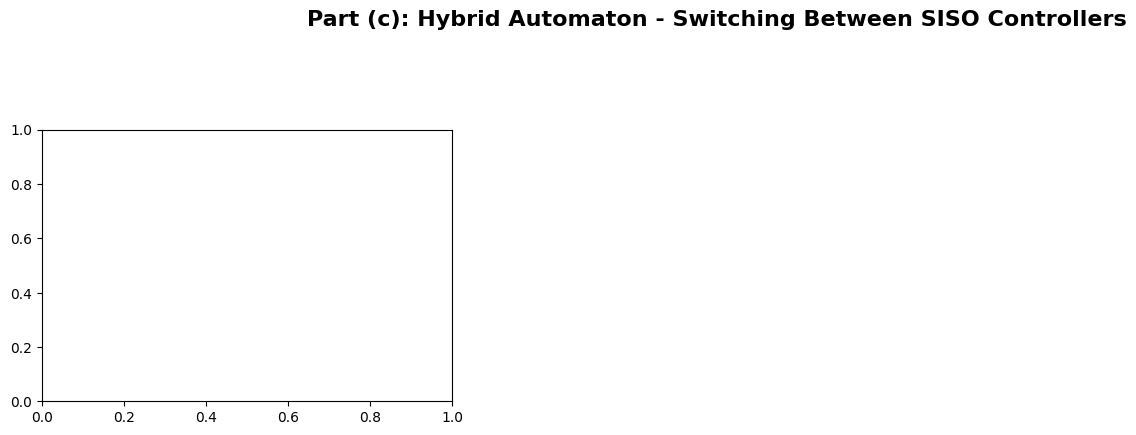

In [ ]:
# Visualize hybrid automaton results
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Part (c): Hybrid Automaton - Switching Between SISO Controllers', fontsize=16, fontweight='bold')

# Temperature trajectories
ax1 = plt.subplot(3, 3, 1)
ax1.plot(T_time[:len(x_c)], x_c[:, 0], 'b-', linewidth=2, label='Tank 1')
ax1.axhline(y=x_ref[0], color='red', linestyle='--', label=f'Reference ({x_ref[0]}C)')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Temperature [C]')
ax1.set_title('Tank 1 Temperature')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 3, 2)
ax2.plot(T_time[:len(x_c)], x_c[:, 1], 'orange', linewidth=2, label='Tank 2')
ax2.axhline(y=x_ref[1], color='red', linestyle='--', label=f'Reference ({x_ref[1]}C)')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Temperature [C]')
ax2.set_title('Tank 2 Temperature')
ax2.legend()
ax2.grid(True, alpha=0.3)

# State space trajectory colored by mode
ax3 = plt.subplot(3, 3, 3)
for mode in [MODE_CTRL1, MODE_CTRL2]:
    mask = mode_traj_c == mode
    if np.any(mask):
        color = 'blue' if mode == MODE_CTRL1 else 'purple'
        ax3.plot(x_c[mask, 0], x_c[mask, 1], 'o', color=color, 
                markersize=3, alpha=0.6, label=mode_names_c[mode])
ax3.plot(x_c[0, 0], x_c[0, 1], 'go', markersize=10, label='Initial', zorder=5)
ax3.plot(x_c[-1, 0], x_c[-1, 1], 'ro', markersize=10, label='Final', zorder=5)
ax3.plot(x_ref[0], x_ref[1], 'r*', markersize=15, label='Reference', zorder=5)
ax3.set_xlabel('T1 [C]')
ax3.set_ylabel('T2 [C]')
ax3.set_title('State Trajectory (Colored by Mode)')
ax3.legend(fontsize=8, loc='best')
ax3.grid(True, alpha=0.3)

# Control signals
ax4 = plt.subplot(3, 3, 4)
ax4.step(T_time[:len(u1_sim_c)], u1_sim_c, 'g-', linewidth=2, where='post', label='u1 (Heater 1)')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Control Signal')
ax4.set_title('Control Signal u1')
ax4.set_ylim([-0.1, 1.1])
ax4.legend()
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(3, 3, 5)
ax5.step(T_time[:len(u2_sim_c)], u2_sim_c, 'm-', linewidth=2, where='post', label='u2 (Heater 2)')
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('Control Signal')
ax5.set_title('Control Signal u2')
ax5.set_ylim([-0.1, 1.1])
ax5.legend()
ax5.grid(True, alpha=0.3)

# Mode trajectory
ax6 = plt.subplot(3, 3, 6)
colors_mode = ['blue', 'purple']
for i in range(len(mode_traj_c)-1):
    ax6.plot([T_time[i], T_time[i+1]], [mode_traj_c[i], mode_traj_c[i]], 
            color=colors_mode[mode_traj_c[i]], linewidth=2)
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('Active Mode')
ax6.set_yticks([0, 1])
ax6.set_yticklabels(['Ctrl 1\n(Tank 1)', 'Ctrl 2\n(Tank 2)'])
ax6.set_title(f'Mode Switching ({mode_switches_c} switches)')
ax6.grid(True, alpha=0.3)

# Error trajectories
ax7 = plt.subplot(3, 3, 7)
error_T1_traj = np.abs(x_c[:, 0] - x_ref[0])
error_T2_traj = np.abs(x_c[:, 1] - x_ref[1])
ax7.plot(T_time[:len(x_c)], error_T1_traj, 'b-', linewidth=2, label='|e_T1|')
ax7.plot(T_time[:len(x_c)], error_T2_traj, 'orange', linewidth=2, label='|e_T2|')
ax7.axhline(y=epsilon_switch, color='red', linestyle='--', alpha=0.5, label=f'Tolerance ({epsilon_switch}C)')
ax7.set_xlabel('Time [s]')
ax7.set_ylabel('Absolute Error [C]')
ax7.set_title('Tracking Errors')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Both controls together
ax8 = plt.subplot(3, 3, 8)
ax8.step(T_time[:len(u1_sim_c)], u1_sim_c, 'g-', linewidth=2, where='post', label='u1')
ax8.step(T_time[:len(u2_sim_c)], u2_sim_c, 'm-', linewidth=2, where='post', label='u2')
ax8.set_xlabel('Time [s]')
ax8.set_ylabel('Control Signal')
ax8.set_title('Both Control Signals')
ax8.set_ylim([-0.1, 1.1])
ax8.legend()
ax8.grid(True, alpha=0.3)

# Both temperatures together
ax9 = plt.subplot(3, 3, 9)
ax9.plot(T_time[:len(x_c)], x_c[:, 0], 'b-', linewidth=2, label='T1')
ax9.plot(T_time[:len(x_c)], x_c[:, 1], 'orange', linewidth=2, label='T2')
ax9.axhline(y=x_ref[0], color='b', linestyle='--', alpha=0.5)
ax9.axhline(y=x_ref[1], color='orange', linestyle='--', alpha=0.5)
ax9.set_xlabel('Time [s]')
ax9.set_ylabel('Temperature [C]')
ax9.set_title('Both Tanks')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Hybrid Control with Optimal Time